#  Market Basket Analysis using Apriori Algorithm

##  Executive Summary

This project performs Market Basket Analysis on retail transaction data <br>
to identify frequently co-purchased products using the Apriori algorithm.<br>

The goal is to extract meaningful association rules that can help <br>
improve cross-selling strategies and recommendation systems.<br>


In [1]:
# visualizaion
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\talib\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# importing dependencies
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

##  Data Loading & Overview

In this step, we load the retail dataset and examine its structure.


In [3]:
# Loading the dataset of online_retail
retail_data=pd.read_excel('Online Retail.xlsx')
retail_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# analyzing the data
retail_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[us]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(1)
memory usage: 40.0+ MB


In [5]:
# checking Null values in the Dataset
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Data Cleaning

We remove:<br>
- Cancelled invoices<br>
- Negative quantities (returns)<br>
- Missing values (if any)<br>

This ensures valid retail transactions for analysis.<br>


In [6]:
# dropping the unneccessary column
data=retail_data.drop('CustomerID',axis=1)
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom


In [7]:
# Now chcking the null values
data.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
dtype: int64

In [8]:
# removing the null values of Description column
df=data.dropna()
df.shape

(540455, 7)

In [9]:
# Checking again no null values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
Country        0
dtype: int64

In [10]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom


In [11]:
# removing the cancelled invoice number
df=df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df.shape

(531167, 7)

In [12]:
# removing the negative quantites
df=df[df['Quantity']>0]
df.shape

(530693, 7)

In [13]:
df.columns=df.columns.str.strip()

## Feature Engineering

Numeric variables such as Quantity and UnitPrice are converted <br>
into categorical bins to make them suitable for association rule mining.<br>


In [14]:
# Now Assign categorical values to the quantity
df['Quantity_Cat']=pd.cut(df['Quantity'],bins=[0,100,1000,100000],labels=['LowQty','MedQty','HighQty'])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Quantity_Cat
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,LowQty
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,LowQty
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,LowQty
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,LowQty
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,LowQty
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,France,LowQty
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France,LowQty
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France,LowQty
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France,LowQty


In [15]:
# Checking the null values
df['Quantity_Cat'].isnull().sum()

np.int64(0)

In [16]:
# Max Value
df['Quantity'].max()

80995

In [17]:
# Minimum Value
df['Quantity'].min()

1

<Axes: xlabel='Quantity', ylabel='Count'>

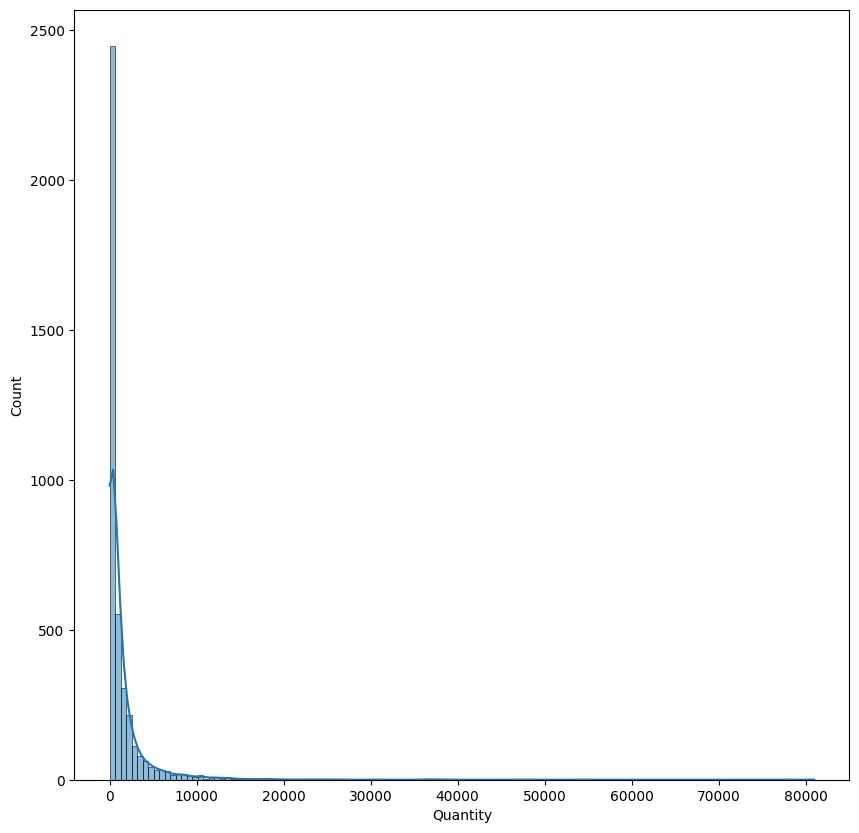

In [18]:
# Top Products
top_product=df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.histplot(top_product,kde=True)

In [19]:
# Now Assign Categorical values to the price
df['Price_Cat']=pd.qcut(df['UnitPrice'],q=3,labels=['LowPrice','MedPrice','HighPrice'])
df['Price_Cat']

0          MedPrice
1         HighPrice
2          MedPrice
3         HighPrice
4         HighPrice
            ...    
541904     LowPrice
541905     MedPrice
541906    HighPrice
541907    HighPrice
541908    HighPrice
Name: Price_Cat, Length: 530693, dtype: category
Categories (3, str): ['LowPrice' < 'MedPrice' < 'HighPrice']

In [20]:
df['Price_Cat'].isnull().sum()

np.int64(0)

## Transaction Preparation

Transactions are grouped by InvoiceNo and converted into a list format.<br>
The TransactionEncoder is used to transform transactions into a one-hot encoded format.<br>


In [21]:
# now took columns and transformed it
transactions=df.groupby('InvoiceNo')[['Description','Price_Cat','Quantity_Cat']].apply(lambda x:list(x['Description'])+
                                                                                               list(x['Price_Cat'].astype(str))+
                                                                                               list(x['Quantity_Cat'].astype(str))).tolist()
                                                                                               
                                                                                                
transactions[1:5]                                                                                            

[['HAND WARMER UNION JACK',
  'HAND WARMER RED POLKA DOT',
  'MedPrice',
  'MedPrice',
  'LowQty',
  'LowQty'],
 ['ASSORTED COLOUR BIRD ORNAMENT',
  "POPPY'S PLAYHOUSE BEDROOM ",
  "POPPY'S PLAYHOUSE KITCHEN",
  'FELTCRAFT PRINCESS CHARLOTTE DOLL',
  'IVORY KNITTED MUG COSY ',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  'BOX OF VINTAGE ALPHABET BLOCKS',
  'HOME BUILDING BLOCK WORD',
  'LOVE BUILDING BLOCK WORD',
  'RECIPE BOX WITH METAL HEART',
  'DOORMAT NEW ENGLAND',
  'MedPrice',
  'MedPrice',
  'MedPrice',
  'HighPrice',
  'MedPrice',
  'HighPrice',
  'HighPrice',
  'HighPrice',
  'HighPrice',
  'HighPrice',
  'HighPrice',
  'HighPrice',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty',
  'LowQty'],
 ['JAM MAKING SET WITH JARS',
  'RED COAT RACK PARIS FASHION',
  'YELLOW COAT RACK PARIS FASHION',
  'BLUE COAT RACK PARIS FASHION',
  'HighPrice',
  'HighPrice',
  'HighPr

In [22]:
# Now encoding the values
te=TransactionEncoder()
te_array=te.fit(transactions).transform(transactions)

# creating the dataframe
te_df=pd.DataFrame(te_array,columns=te.columns_)
te_df.head(1)

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Frequent Itemset Generation

The Apriori algorithm is applied to identify frequent itemsets <br>
based on a minimum support threshold.<br>


In [23]:
# applying the aprior algorithm
fe_pat=apriori(te_df,min_support=0.2,use_colnames=True)
fe_pat

,support,itemsets
0,0.840733,frozenset({HighPrice})
1,0.828069,frozenset({LowPrice})
2,0.977602,frozenset({LowQty})
3,0.850765,frozenset({MedPrice})
4,0.707390,"frozenset({HighPrice, LowPrice})"
5,0.836760,"frozenset({HighPrice, LowQty})"
6,0.743047,"frozenset({MedPrice, HighPrice})"
7,0.813518,"frozenset({LowQty, LowPrice})"
8,0.738131,"frozenset({MedPrice, LowPrice})"
9,0.843464,"frozenset({MedPrice, LowQty})"


In [24]:
fe_pat.shape

(15, 2)

## Association Rule Mining

Association rules are generated using support, confidence, and lift metrics.<br>
Rules with lift greater than 1 are considered meaningful.


In [25]:
# applying the association rule
rules=association_rules(fe_pat,metric='confidence',min_threshold=0.1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({LowPrice}),frozenset({HighPrice}),0.828069,0.840733,0.707390,0.854264,1.016094,1.0,0.011205,1.092847,0.092127,0.735782,0.084959,0.847830
1,frozenset({HighPrice}),frozenset({LowPrice}),0.840733,0.828069,0.707390,0.841396,1.016094,1.0,0.011205,1.084029,0.099452,0.735782,0.077515,0.847830
2,frozenset({LowQty}),frozenset({HighPrice}),0.977602,0.840733,0.836760,0.855931,1.018077,1.0,0.014857,1.105490,0.792759,0.852466,0.095424,0.925603
3,frozenset({HighPrice}),frozenset({LowQty}),0.840733,0.977602,0.836760,0.995274,1.018077,1.0,0.014857,4.739632,0.111486,0.852466,0.789013,0.925603
4,frozenset({MedPrice}),frozenset({HighPrice}),0.850765,0.840733,0.743047,0.873387,1.038840,1.0,0.027781,1.257908,0.250532,0.783433,0.205029,0.878598
5,frozenset({HighPrice}),frozenset({MedPrice}),0.840733,0.850765,0.743047,0.883809,1.038840,1.0,0.027781,1.284394,0.234752,0.783433,0.221423,0.878598
6,frozenset({LowPrice}),frozenset({LowQty}),0.828069,0.977602,0.813518,0.982428,1.004936,1.0,0.003996,1.274605,0.028568,0.819952,0.215443,0.907292
7,frozenset({LowQty}),frozenset({LowPrice}),0.977602,0.828069,0.813518,0.832156,1.004936,1.0,0.003996,1.024352,0.219297,0.819952,0.023773,0.907292
8,frozenset({MedPrice}),frozenset({LowPrice}),0.850765,0.828069,0.738131,0.867608,1.047749,1.0,0.033639,1.298654,0.305375,0.784658,0.229972,0.879498
9,frozenset({LowPrice}),frozenset({MedPrice}),0.828069,0.850765,0.738131,0.891388,1.047749,1.0,0.033639,1.374019,0.265064,0.784658,0.272208,0.879498


In [26]:
# For Positive Relations
rules=rules[rules['lift']>1.1]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
20,"frozenset({HighPrice, LowPrice})",frozenset({MedPrice}),0.707390,0.850765,0.669001,0.945732,1.111625,1.0,0.067178,2.749943,0.343174,0.752402,0.636356,0.866042
21,frozenset({MedPrice}),"frozenset({HighPrice, LowPrice})",0.850765,0.707390,0.669001,0.786352,1.111625,1.0,0.067178,1.369592,0.672872,0.752402,0.269855,0.866042
39,"frozenset({HighPrice, LowQty, LowPrice})",frozenset({MedPrice}),0.706496,0.850765,0.668256,0.945874,1.111792,1.0,0.067194,2.757169,0.342589,0.751690,0.637309,0.865675
41,"frozenset({MedPrice, LowQty})","frozenset({HighPrice, LowPrice})",0.843464,0.707390,0.668256,0.792275,1.119998,1.0,0.071598,1.408643,0.684453,0.757146,0.290097,0.868477
42,"frozenset({MedPrice, HighPrice})","frozenset({LowQty, LowPrice})",0.743047,0.813518,0.668256,0.899345,1.105501,1.0,0.063773,1.852684,0.371402,0.752278,0.460243,0.860392
43,"frozenset({LowQty, LowPrice})","frozenset({MedPrice, HighPrice})",0.813518,0.743047,0.668256,0.821439,1.105501,1.0,0.063773,1.439023,0.511753,0.752278,0.305084,0.860392
44,"frozenset({HighPrice, LowPrice})","frozenset({MedPrice, LowQty})",0.707390,0.843464,0.668256,0.944678,1.119998,1.0,0.071598,2.829559,0.366157,0.757146,0.646588,0.868477
46,frozenset({MedPrice}),"frozenset({HighPrice, LowQty, LowPrice})",0.850765,0.706496,0.668256,0.785477,1.111792,1.0,0.067194,1.368169,0.673778,0.751690,0.269096,0.865675


In [27]:
print(f'Max lift:{rules['lift'].max():.4f}')
print(f'Max confidence:{rules['confidence'].max():.4f}')

Max lift:1.1200
Max confidence:0.9459


In [28]:
print('--------------------Values of Max Lift Antecedents & Consequents----------------------------')
print(rules.groupby('consequents')['lift'].max())
print('\n---------------------------------------------------------------------------')
print(rules.groupby('antecedents')['lift'].max())


--------------------Values of Max Lift Antecedents & Consequents----------------------------
consequents
frozenset({MedPrice})                       1.111792
frozenset({HighPrice, LowPrice})            1.119998
frozenset({LowQty, LowPrice})               1.105501
frozenset({MedPrice, HighPrice})            1.105501
frozenset({MedPrice, LowQty})               1.119998
frozenset({HighPrice, LowQty, LowPrice})    1.111792
Name: lift, dtype: float64

---------------------------------------------------------------------------
antecedents
frozenset({HighPrice, LowPrice})            1.119998
frozenset({MedPrice})                       1.111792
frozenset({HighPrice, LowQty, LowPrice})    1.111792
frozenset({MedPrice, LowQty})               1.119998
frozenset({MedPrice, HighPrice})            1.105501
frozenset({LowQty, LowPrice})               1.105501
Name: lift, dtype: float64


In [29]:
print(rules.groupby('consequents')['confidence'].max())


consequents
frozenset({MedPrice})                       0.945874
frozenset({HighPrice, LowPrice})            0.792275
frozenset({LowQty, LowPrice})               0.899345
frozenset({MedPrice, HighPrice})            0.821439
frozenset({MedPrice, LowQty})               0.944678
frozenset({HighPrice, LowQty, LowPrice})    0.785477
Name: confidence, dtype: float64


In [30]:
rules=rules[['antecedents','consequents','support','confidence','lift']]
rules['antecedents']=rules['antecedents'].apply(lambda x:','.join(list(x)))
rules['consequents']=rules['consequents'].apply(lambda x:','.join(list(x)))
rules.head()

,antecedents,consequents,support,confidence,lift
20,"HighPrice,LowPrice",MedPrice,0.669001,0.945732,1.111625
21,MedPrice,"HighPrice,LowPrice",0.669001,0.786352,1.111625
39,"HighPrice,LowQty,LowPrice",MedPrice,0.668256,0.945874,1.111792
41,"MedPrice,LowQty","HighPrice,LowPrice",0.668256,0.792275,1.119998
42,"MedPrice,HighPrice","LowQty,LowPrice",0.668256,0.899345,1.105501


## Visualization & Insights

The following visualizations help interpret the strength and quality of association rules.


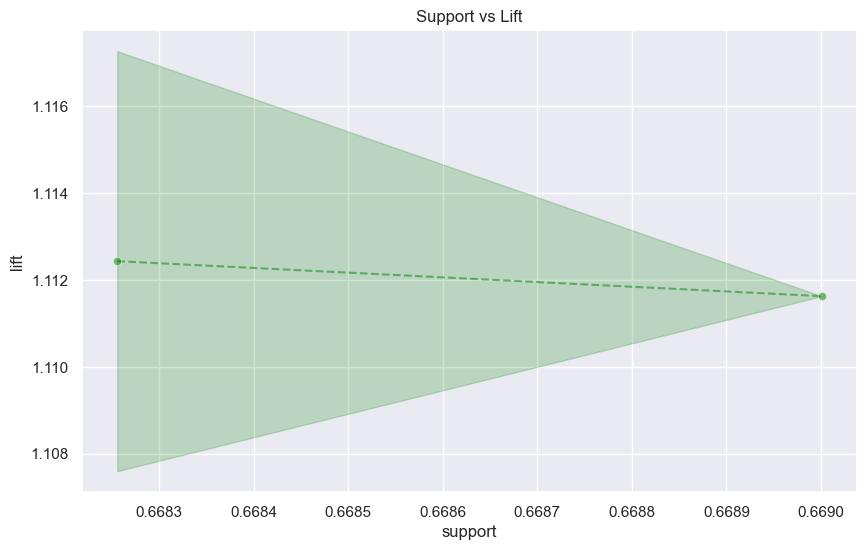

In [43]:
# Support vs Lift
sns.set_style("darkgrid")
sns.set_context("notebook")
plt.figure(figsize=(10,6))
sns.lineplot(x='support',y='lift',data=rules,marker="o",ls="--",alpha=0.5,color="green")
plt.title('Support vs Lift')
plt.show()

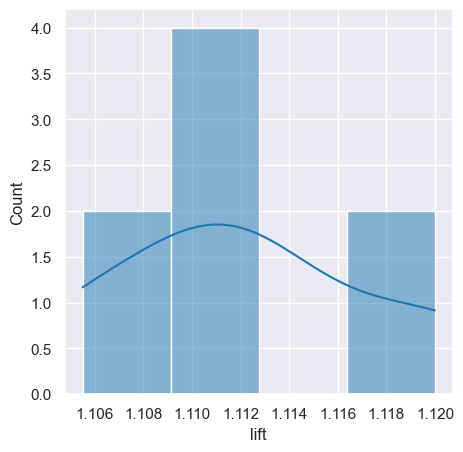

In [37]:
# Lift Distribution
plt.figure(figsize=(5,5))
sns.histplot(rules['lift'],kde=True)
plt.show()

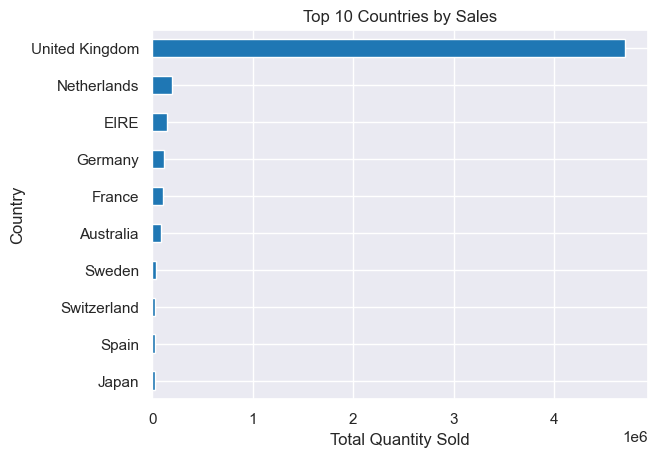

In [40]:
# Country wise sells
country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
top_countries = country_sales.head(10)

top_countries.plot(kind='barh')
plt.xlabel("Total Quantity Sold")
plt.title("Top 10 Countries by Sales")
plt.gca().invert_yaxis()
plt.show()


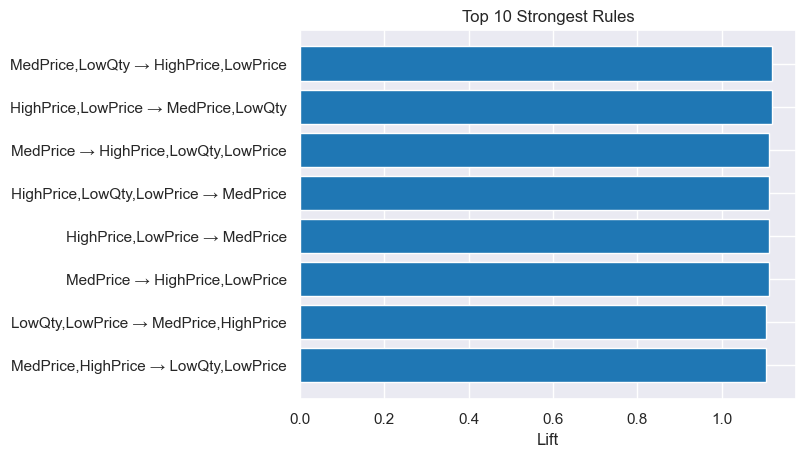

In [41]:
top_rules = rules.sort_values(by='lift', ascending=False).head(10)

plt.barh(range(len(top_rules)), top_rules['lift'])
plt.yticks(range(len(top_rules)), 
           top_rules['antecedents'].astype(str) + " → " + top_rules['consequents'].astype(str))
plt.xlabel("Lift")
plt.title("Top 10 Strongest Rules")
plt.gca().invert_yaxis()
plt.show()


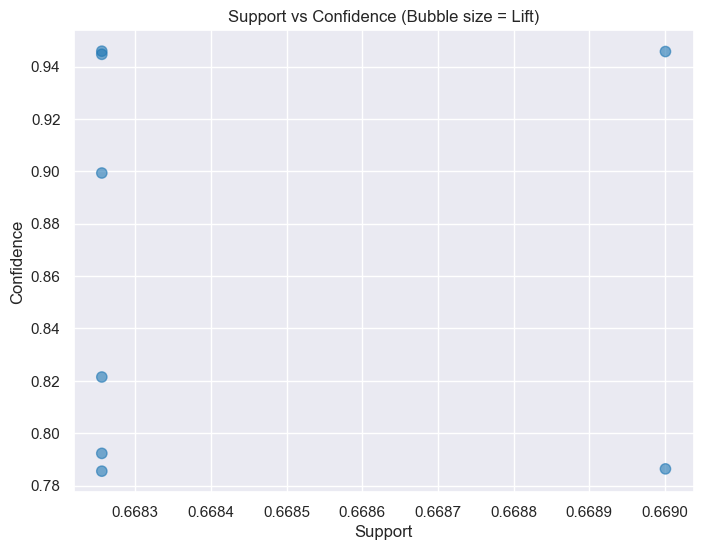

In [42]:
plt.figure(figsize=(8,6))

# Normalize lift for bubble size
sizes = rules['lift'] * 50  

plt.scatter(
    rules['support'],
    rules['confidence'],
    s=sizes,
    alpha=0.6
)

plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Support vs Confidence (Bubble size = Lift)")
plt.grid(True)

plt.show()

## Key Insights

- Strong rules with high lift indicate meaningful product associations.<br>
- High-confidence rules show predictable co-purchase behavior.<br>
- These associations can support product bundling and recommendation systems.<br>

## Conclusion

The Apriori-based Market Basket Analysis successfully uncovered <br>
valuable purchasing patterns that can help drive data-driven business decisions.<br>
